## Condensation of the first solids in the Solar System

For this exercise, we will try to predict what the first solids to condense in the Solar System will be. This is based on the work by <a href = 'https://doi.org/10.1016/0016-7037(72)90078-6'>Grossman (1972)</a>. As you may recall, this work has revolutionized the field of cosmochemistry as it has been one of the first works to successfully match the mineralogy of refractory inclusions in meteorites, which were later recognized as the first condensates in the Solar System. While not the first to work on equilibrium condensation from the nebular gas, it was the first to implement a scheme where the calculation parameters were reconfigured whenever the condensation of new mineral phases starts. Here, we will deal with a very simplified version of these calculations

<i> Sections 1 to 4 are mainly for reading/instruction for you to understand how the calculation works. The main code that you're gonna be running is at Section 5. However, the data import and interpolation functions at section 3 need to be run so you can use the `calcNP` function in Section 5 </i>

### 0. Some table-setting so our code works

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['font.sans-serif'] = "Arial"
%matplotlib inline

from scipy.interpolate import interp1d as interp
from scipy.optimize import fsolve

### 1. Some key assumptions, parameters and constants 

Recall that one key assumption in <a href = 'https://doi.org/10.1016/0016-7037(72)90078-6'>Grossman (1972)</a> is that most of the gas in the nebula is in the form of $H_2$ gas such that:

$$P_{H_2} = P_H^{TOT} = P^{TOT}$$

where $P_H^{TOT}$ is the partial pressure for all H-bearing species and $P^{TOT}$ is the total pressure of the nebula. 

Another key part of this calculation is the assumption of ideality, which is valid given the low pressure (see the very low value of variable `PH2` below, representative of $P_{H_2}$) and high temperature (`Tk`). 

In [2]:
PH2  = 1e-3 # (atm) - partial pressure of hydrogen gas
Tk   = 1850 # K - temperature

Rgc  = 8.3144621 # (L*bar/K/mol) - gas constant
Ratm = 0.08205746 # - gas constant

### 2. Solar System Abundances

Solar System abundances are expressed relative to the abundance of silicon, which in this scheme is fixed as $10^6$ (see Table 1, pp. 599 of <a href = 'https://doi.org/10.1016/0016-7037(72)90078-6'>Grossman, 1972</a>). These values are based on measurements on meteorites - specifically CI chondrites. 

Here we get the abundances of the elements that we will be tracking for this calculation.

In [3]:
AbH  = 2.79e10 # Hydrogen
AbO  = 2.38e7  # Oxygen
AbC  = 1.01e7  # Carbon
AbAl = 8.49e4  # Aluminum

### 3. Calculating the $K_{eq}$ for a given T

For this part, we need to extract/organize the thermodynamic data (from <a href='https://janaf.nist.gov/'>NIST-JANAF</a>) that we will be using for this calculation. While there are more straightforward ways to do this (*can't I just type this out as long lists in the code?*), one can imagine that if we were tracking more species, this organization can come in handy. 

Note that the species names are followed by the phase it's in (*i.e.,* **g** = gas, **c** = condensate). The enthalpy of formation ($\Delta H_f^{\circ}$) are in $kJ\cdot mol^{-1}$ while the standard molar entropy ($S^{\circ}$) are in $J\cdot K^{-1}mol^{-1}$. 

In [5]:
rawdat  = pd.read_excel('ps3_thermo_dat.xlsx')

# We extract the different/unique species in this data set
species = np.unique(rawdat['species'])

print('The file input has data for the following species:',species)   

# Constructing a dictionary 'thermodat' from the raw data - mostly for organization
thermodat = dict((sp,0) for sp in species)

for sp in thermodat.keys():
    
    # Look for the data relevant to one species
    df = rawdat.loc[rawdat['species'] == sp]
    
    # Get temperature, enthalpy, and entropy data for these species
    T  = df.loc[df['var'] == 'T']['val'].reset_index(drop=True)
    H  = df.loc[df['var'] == 'H']['val'].reset_index(drop=True)
    S  = df.loc[df['var'] == 'S']['val'].reset_index(drop=True)
    
    thermodat[sp] = pd.DataFrame({'T':T,'H':H,'S':S})

The file input has data for the following species: ['Al2O3_c' 'AlOH_g' 'Al_g' 'H2O_g' 'H2_g' 'H_g' 'O_g']


For the species we are tracking, we consider the following chemical reactions for the gaseous species:


$$H_{(g)} + H_{(g)} = H_{2 (g)}$$ 
$$2H_{(g)} + O_{(g)} = H_{2}O_{(g)}$$ 
$$Al_{(g)} + O_{(g)} + H_{(g)} = AlOH_{(g)}$$ 

and one for the condensate corundum:

$$2Al_{(g)} + 3O_{(g)} = Al_2O_{3(c)}$$ 

**Ultimately, we want to get the equilibrium constant ($K_{eq}$ ) of these reactions, as it will help get us  additional expressions that we can use to solve for a system of equations that involves the molar density and partial pressure of each species.** In order to get the $K_{eq}$ for each particular reaction, we must first calculate the standard enthalpy and entropy change of reaction for each. The formulae for these take on very similar forms - for the following reaction:

$$aA + bB = cC + dD$$

The standard enthalpy and entropy change of reaction ($\Delta H_{rxn}^{\circ}$ and $\Delta S^{\circ}$, respectively) are as follows:

$$\Delta H_{rxn}^{\circ} = c\Delta H_f^{\circ}(C) + d\Delta H_f^{\circ}(D) -  a\Delta H_f^{\circ}(A) - b\Delta H_f^{\circ}(B)$$
$$\Delta S^{\circ} = \underbrace{c\Delta S^{\circ}(C) + d\Delta S^{\circ}(D)}_\text{products} - \underbrace{a\Delta S^{\circ}(A) - b\Delta S^{\circ}(B)}_\text{reactants}$$

We can then calculate these values for the reactions above. Note however that we don't have the exact $\Delta H_f^{\circ}$ and $S^{\circ}$ for the temperature of the system (here, T = 1850K). We can simply do a linear interpolation (using `interp`) with the data that we do have and extract $\Delta H_f^{\circ}$ and $S^{\circ}$ from this function.

<font color ='A40802'> 
<i><b> TIP 1: </b> For the function that you will be putting in the loop, there's no need to put the interpolation functions in there. However, the calculations for $\Delta H_f^{\circ}$ and $S^{\circ}$ should be in there as these would vary with temperature</i><br>
</font>    

In [6]:
# Getting the delta-H formation and S interpolation functions

Hf_H_g      = interp(thermodat['H_g']['T'],thermodat['H_g']['H'],fill_value="extrapolate")
Hf_H2_g     = interp(thermodat['H2_g']['T'],thermodat['H2_g']['H'],fill_value="extrapolate")
Hf_O_g      = interp(thermodat['O_g']['T'],thermodat['O_g']['H'],fill_value="extrapolate")
Hf_H2O_g    = interp(thermodat['H2O_g']['T'],thermodat['H2O_g']['H'],fill_value="extrapolate")
Hf_Al_g     = interp(thermodat['Al_g']['T'],thermodat['Al_g']['H'],fill_value="extrapolate")
Hf_AlOH_g   = interp(thermodat['AlOH_g']['T'],thermodat['AlOH_g']['H'],fill_value="extrapolate")
Hf_Al2O3_c  = interp(thermodat['Al2O3_c']['T'],thermodat['Al2O3_c']['H'],fill_value="extrapolate")

S_H_g       = interp(thermodat['H_g']['T'],thermodat['H_g']['S'],fill_value="extrapolate")
S_H2_g      = interp(thermodat['H2_g']['T'],thermodat['H2_g']['S'],fill_value="extrapolate")
S_O_g       = interp(thermodat['O_g']['T'],thermodat['O_g']['S'],fill_value="extrapolate")
S_H2O_g     = interp(thermodat['H2O_g']['T'],thermodat['H2O_g']['S'],fill_value="extrapolate")
S_Al_g      = interp(thermodat['Al_g']['T'],thermodat['Al_g']['S'],fill_value="extrapolate")
S_AlOH_g    = interp(thermodat['AlOH_g']['T'],thermodat['AlOH_g']['S'],fill_value="extrapolate")
S_Al2O3_c   = interp(thermodat['Al2O3_c']['T'],thermodat['Al2O3_c']['S'],fill_value="extrapolate")

# Calculating the delta-H rxn and delta-S for the reactions

#             products           reactants 
#             --------           ---------       
dH_H2_g     = Hf_H2_g(Tk)    -  (2 * Hf_H_g(Tk))
dH_H2O_g    = Hf_H2O_g(Tk)   -  (2 * Hf_H_g(Tk) + Hf_O_g(Tk))
dH_AlOH_g   = Hf_AlOH_g(Tk)  -  (Hf_Al_g(Tk) + Hf_O_g(Tk) + Hf_H_g(Tk))
dH_Al2O3_c  = Hf_Al2O3_c(Tk) -  (2 * Hf_Al_g(Tk) + 3 * Hf_O_g(Tk))

dS_H2_g     = S_H2_g(Tk)     -  (2 * S_H_g(Tk))
dS_H2O_g    = S_H2O_g(Tk)    -  (2 * S_H_g(Tk) + S_O_g(Tk))
dS_AlOH_g   = S_AlOH_g(Tk)   -  (S_Al_g(Tk) + S_O_g(Tk) + S_H_g(Tk))
dS_Al2O3_c  = S_Al2O3_c(Tk)  -  (2 * S_Al_g(Tk) + 3 * S_O_g(Tk))

From here, we can calculate the Gibbs Free Energy of reaction ($\Delta G^{\circ}$):

$$\Delta G^{\circ} = \Delta H_{rxn}^{\circ} - T\cdot \Delta S^{\circ}$$

 and subsequently, we can calculate $K_{eq}$ using the following expression:
 
$$K_{eq} = e^{(-\Delta G^{\circ}/RT)}$$

In [9]:
# Gibbs Free Energy of Reaction
# Note that delta-H rxn values are multiplied by 1000 to convert it to J/mol

dG_H2_g     = 1000 * dH_H2_g      -   Tk * dS_H2_g
dG_H2O_g    = 1000 * dH_H2O_g     -   Tk * dS_H2O_g
dG_AlOH_g   = 1000 * dH_AlOH_g    -   Tk * dS_AlOH_g
dG_Al2O3_c  = 1000 * dH_Al2O3_c   -   Tk * dS_Al2O3_c

Keq_H2_g    = np.exp(-dG_H2_g/Rgc/Tk)
Keq_H2O_g   = np.exp(-dG_H2O_g/Rgc/Tk)
Keq_AlOH_g  = np.exp(-dG_AlOH_g/Rgc/Tk)
Keq_Al2O3_c = np.exp(-dG_Al2O3_c/Rgc/Tk)

### 4. Solving for the molar densities ($N$) and partial pressures ($P$)

Given the low total pressure (`PH2` = $10^{-3}$ atm) and high temperatures (T = 1500 to 2000 K), we can assume ideal behvaior for the gaseous species. For hydrogen gas:

$$N_{H_2} = P_{H_2}/RT$$

where $N_{H_2}$ and $P_{H_2}$ are the molar density and partial pressure of the hydrogen gas, respectively. Since we assume that hydrogen gas comprises all the hydrogen in the nebula:

$$2 \cdot N_{H_2} = N_{H}^{TOT}$$

Using the relative abundances, we can determine the molar density of any element X:

$$N_X^{TOT}= N_H^{TOT} \cdot A(X)/A(H)$$

We can then write the expressions (and solve) for $N_{Al}^{TOT}$ and $N_{O}^{TOT}$:

$$N_{Al}^{TOT} = A(Al)/A(H) \cdot N_{H}^{TOT}$$
$$N_{O}^{TOT}  = A(O)/A(H)  \cdot N_{H}^{TOT}$$

In [10]:
NHTot  = 2*PH2/(Ratm*Tk)
NOTot  = AbO/AbH*NHTot
NAlTot = AbAl/AbH*NHTot

With these additional constants, we can finally write six equations, which includes six unknowns - the molar density of the six *gaseous* species. 

Writing the total molar densities for each element in terms of the molar densities of each species:
1. $$N_H^{TOT} = N_{H(g)} + 2\cdot N_{H_2(g)} + 2\cdot N_{H_2O(g)}$$
2. $$N_O^{TOT} = N_{O(g)} + N_{H_2O(g)} + N_{AlOH_(g)}$$
3. $$N_{Al}^{TOT} = N_{Al(g)} + N_{AlOH(g)}$$

Now, the reward from calculating all of those $K_{eq}$ values come in the form of three additional equations for the gaseous species:

4. $$K_{eq}^{H_2} = (N_{H_2(g)}/N_{H(g)}^2)/(RT) \rightarrow N_{H_2(g)} = K_{eq}^{H_2}\cdot N_{H(g)}^2\cdot RT$$ 
5. $$K_{eq}^{H_2O} = [N_{H_2O(g)}/(N_{H(g)}^2\cdot N_{O(g)})]/(RT)^2 \rightarrow N_{H_2O(g)} = K_{eq}^{H_2O}\cdot N_{H(g)}^2\cdot N_{O(g)}\cdot (RT)^2$$ 
6. $$K_{eq}^{AlOH} = [N_{AlOH_(g)}/(N_{Al(g)}\cdot N_{O(g)}\cdot N_{H(g)})]/(RT)^2 \rightarrow N_{AlOH_(g)} = K_{eq}^{AlOH}\cdot N_{Al(g)}\cdot N_{O(g)}\cdot N_{H(g)}\cdot(RT)^2$$ 

Given that these last three equations are non-linear, we use the `fsolve` function from the SciPy optimization toolbox. For equations 4-6, we use the version to the right as it would be easier for the solver to not deal with quotients between very small numbers.

From the calculated molar densities, we can easily get the partial pressures of these gaseous species:

$$P_X = N_X\cdot RT$$

<font color ='A40802'> 
<i><b> TIP 2: </b> Always make sure that the number of input variables is the same as the number of equations. Needless to say, the number of elements in the initial guess should also match. <br>
<b> TIP 3: </b> When adding a chemical species, make sure that is included in the equations that account for the  total molar density (in the example below, eq 1 to 3)</i>
</font>    

<font color ='A40802'> <b> Note that the are three (3) typos in the declared equations </b></font>

In [11]:
def sysofeq(vars):
    # Using variable names to make the equations more understandable
    nH, nH2, nH2O, nO, nAl, nAlOH = vars[0:6]
    
    # Writing down the equations from above
    #      LHS             RHS
    #      ---             ---
    eq1 =  NHTot      -   (nH + nH2 + 2*nH2O)
    eq2 =  NOTot      -   (nO + nH2O + nAlOH)
    eq3 =  NAlTot     -   (nAl + nAlOH + nAl2O3)

    eq4 =  nH2        -   Keq_H2_g * nH * Ratm*Tk
    eq5 =  nH2O       -   Keq_H2O_g * 2*nH * nO * Ratm**2 * Tk**2
    eq6 =  nAlOH      -   Keq_AlOH_g * nAl * nO * nH * Ratm**2 * Tk**2
    
    if cor condensing:
        eq7 = 1 - keq
    else:   
        eq7 = nAl2O3
    
    return [eq1,eq2,eq3,eq4,eq5,eq6]

# Initial guess - value really doesn't matter that much
N0   = [0.001,0.001,0.001,0.001,0.001,0.001]

# Solving for the actual values for N 
N    = fsolve(sysofeq,N0)

# Solving for the partial pressures
P    = N * Ratm*Tk
logP = np.log10(P)

/Users/ren/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in log10


In [12]:
print('At a temperature of ',Tk,' Kelvin:')
print('1. H has a partial pressure of ',"{:.2e}".format(P[0]),'atm, and makes up ',"{:.4f}".format(100*N[0]/NHTot),'% of total H.')
print('2. H2 has a partial pressure of ',"{:.2e}".format(P[1]),'atm, and makes up ',"{:.4f}".format(2*100*N[1]/NHTot),'% of total H.')
print('3. H2O has a partial pressure of ',"{:.2e}".format(P[2]),'atm, and makes up ',"{:.4f}".format(2*100*N[2]/NHTot),'% of total H and ',"{:.4f}".format(100*N[2]/NOTot),'% of total O.')
print('4. O has a partial pressure of ',"{:.2e}".format(P[3]),'atm, and makes up ',"{:.4f}".format(100*N[3]/NOTot),'% of total O.')
print('5. Al has a partial pressure of ',"{:.2e}".format(P[4]),'atm, and makes up ',"{:.4f}".format(100*N[4]/NAlTot),'% of total Al.')
print('6. AlOH has a partial pressure of ',"{:.2e}".format(P[5]),'atm, and makes up ',"{:.4f}".format(100*N[5]/NAlTot),'% of total Al,',"{:.4f}".format(100*N[5]/NOTot),'% of total O, and',"{:.4f}".format(100*N[5]/NHTot),'% of total H')

At a temperature of  1850  Kelvin:
1. H has a partial pressure of  3.23e-12 atm, and makes up  0.0000 % of total H.
2. H2 has a partial pressure of  2.00e-03 atm, and makes up  199.6596 % of total H.
3. H2O has a partial pressure of  1.70e-06 atm, and makes up  0.1702 % of total H and  99.7583 % of total O.
4. O has a partial pressure of  1.52e-01 atm, and makes up  8897890.2070 % of total O.
5. Al has a partial pressure of  1.52e-01 atm, and makes up  2494343812.3195 % of total Al.
6. AlOH has a partial pressure of  -1.52e-01 atm, and makes up  -2494343712.3195 % of total Al, -8897889.9654 % of total O, and -7590.3147 % of total H


<font color ='A40802'> <b> Looking at the (non-sensical) outputs displayed above, it's clear that there are typos in the declared equations above.</b></font>

### 5. Condensation of Space Sapphires

So far, we have only dealt with gaseous species in the nebula. But, as you may have guessed, the condensation of minerals results to significant changes in the relative abundances of the remaining gaseous species. This is at the core of what made the calculations by <a href = 'https://doi.org/10.1016/0016-7037(72)90078-6'>Grossman (1972)</a> so successful in predicting the first solids to condense from the nebula - once the system reaches a point where a mineral starts condensing, he modified the equations to match this such that the trajectory of the gases' partial pressures changes. 

Here, we examine the condensation of the first mineral in the Solar System, **corundum** ($Al_2O_3$ - aka Sapphire, Ruby). 

First, we need to make use of our newly-acquired skill of calculating molar densities and partial pressures at a given temperature. We can essentially take the code from above and re-write it as a function, which we can then iterate through a loop for different temperatures. Once you have a working function and loop to do this, you should be able to replicate the figure in question (i) of the problem set. <br>

<font color ='A40802'> <b> Note again that the are three (3) typos in the declared equations </b></font>

In [7]:
def calcNP(Tk):

    # Calculating the delta-H rxn and delta-S for the reactions

    #             products           reactants 
    #             --------           ---------       
    dH_H2_g     = Hf_H2_g(Tk)    -  (2 * Hf_H_g(Tk))
    dH_H2O_g    = Hf_H2O_g(Tk)   -  (2 * Hf_H_g(Tk) + Hf_O_g(Tk))
    dH_AlOH_g   = Hf_AlOH_g(Tk)  -  (Hf_Al_g(Tk) + Hf_O_g(Tk) + Hf_H_g(Tk))
    dH_Al2O3_c  = Hf_Al2O3_c(Tk) -  (2 * Hf_Al_g(Tk) + 3 * Hf_O_g(Tk))

    dS_H2_g     = S_H2_g(Tk)     -  (2 * S_H_g(Tk))
    dS_H2O_g    = S_H2O_g(Tk)    -  (2 * S_H_g(Tk) + S_O_g(Tk))
    dS_AlOH_g   = S_AlOH_g(Tk)   -  (S_Al_g(Tk) + S_O_g(Tk) + S_H_g(Tk))
    dS_Al2O3_c  = S_Al2O3_c(Tk)  -  (2 * S_Al_g(Tk) + 3 * S_O_g(Tk))
    
    # Gibbs Free Energy of Reaction
    # Note that delta-H rxn values are multiplied by 1000 to convert it to J/mol

    dG_H2_g     = 1000 * dH_H2_g      -   Tk * dS_H2_g
    dG_H2O_g    = 1000 * dH_H2O_g     -   Tk * dS_H2O_g
    dG_AlOH_g   = 1000 * dH_AlOH_g    -   Tk * dS_AlOH_g
    dG_Al2O3_c  = 1000 * dH_Al2O3_c   -   Tk * dS_Al2O3_c

    Keq_H2_g    = np.exp(-dG_H2_g/Rgc/Tk)
    Keq_H2O_g   = np.exp(-dG_H2O_g/Rgc/Tk)
    Keq_AlOH_g  = np.exp(-dG_AlOH_g/Rgc/Tk)
    Keq_Al2O3_c = np.exp(-dG_Al2O3_c/Rgc/Tk)
    
    NHTot  = 2*PH2/(Ratm*Tk)
    NOTot  = AbO/AbH*NHTot
    NAlTot = AbAl/AbH*NHTot 
    
    def sysofeq(vars):
        # Using variable names to make the equations more understandable
        nH, nH2, nH2O, nO, nAl, nAlOH = vars[0:6]

        # Writing down the equations from above
        #      LHS             RHS
        #      ---             ---
        eq1  =  NHTot      -   (nH + 2*nH2 + 2*nH2O)
        eq2  =  NOTot      -   (nO + nH2O + nAlOH)
        eq3  =  NAlTot     -   (nAl + nAlOH)

        eq4  =  nH2        -   Keq_H2_g * nH**2 * Ratm*Tk
        eq5  =  nH2O       -   Keq_H2O_g * nH**2 * nO * Ratm**2 * Tk**2
        eq6  =  nAlOH      -   Keq_AlOH_g * nAl * nO * nH * Ratm**2 * Tk**2 
       
        return [eq1,eq2,eq3,eq4,eq5,eq6]

    # Solving for the actual values for N 
    N        = fsolve(sysofeq,N0)
        
    # Solving for the partial pressures
    P        = N * Ratm*Tk 
    logP     = np.log10(P)
    
    return N,logP,Keq_Al2O3_c

In [9]:
nebdat = pd.DataFrame(columns = ('nH', 'nH2', 'nH2O', 'nO', 'nAl', 'nAlOH',\
                                 'pH', 'pH2', 'pH2O', 'pO', 'pAl', 'pAlOH','k'))


# Range of temperatures considered for calculation
T_range = np.linspace(2000,1500,501)

# Initial initial
N0      = [0.001,0.001,0.001,0.001,0.001,0.001]

for i in range(len(T_range)):

    N,logP,k      = calcNP(T_range[i])
    
    nebdat.loc[i] = np.concatenate((N,logP,[k]))
    N0            = N

In [11]:
nebdat['k']

0      8.989723e+40
1      9.853403e+40
2      1.080107e+41
3      1.184100e+41
4      1.298227e+41
           ...     
496    2.020970e+67
497    2.379263e+67
498    2.801693e+67
499    3.299852e+67
500    3.887447e+67
Name: k, Length: 501, dtype: float64

In [31]:
nebdat

,nH,nH2,nH2O,nO,nAl,nAlOH,pH,pH2,pH2O,pO,pAl,pAlOH
0,3.094959e-07,0.000006,1.039084e-08,2.062628e-12,3.426044e-11,2.823457e-12,-4.294197,-3.011933,-5.768201,-9.470431,-8.250059,-9.334071
1,3.075694e-07,0.000006,1.039605e-08,2.032066e-12,3.425686e-11,2.845592e-12,-4.297126,-3.011856,-5.768201,-9.477131,-8.250322,-9.330897
2,3.056529e-07,0.000006,1.040126e-08,2.001929e-12,3.425317e-11,2.867851e-12,-4.300058,-3.011781,-5.768201,-9.483838,-8.250586,-9.327730
3,3.037462e-07,0.000006,1.040648e-08,1.972212e-12,3.424932e-11,2.890295e-12,-4.302993,-3.011705,-5.768200,-9.490550,-8.250852,-9.324562
4,3.018493e-07,0.000006,1.041170e-08,1.942909e-12,3.424529e-11,2.912926e-12,-4.305931,-3.011630,-5.768200,-9.497269,-8.251121,-9.321392
...,...,...,...,...,...,...,...,...,...,...,...,...
496,4.731280e-09,0.000008,1.377771e-08,1.177242e-16,2.922038e-12,4.639166e-11,-6.233655,-3.000866,-5.769457,-13.837768,-9.442948,-8.242194
497,4.678186e-09,0.000008,1.378684e-08,1.146836e-16,2.885188e-12,4.646132e-11,-6.238845,-3.000865,-5.769458,-13.849422,-9.448749,-8.241831
498,4.625618e-09,0.000008,1.379598e-08,1.117175e-16,2.848721e-12,4.653064e-11,-6.244042,-3.000863,-5.769460,-13.861091,-9.454562,-8.241473
499,4.573572e-09,0.000008,1.380513e-08,1.088245e-16,2.812633e-12,4.659963e-11,-6.249246,-3.000862,-5.769461,-13.872775,-9.460388,-8.241119


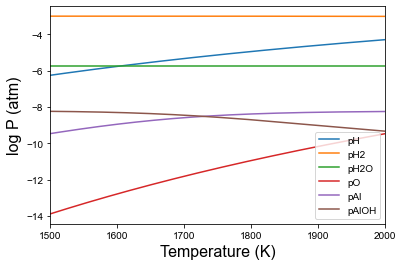

In [20]:
plt.plot(T_range,nebdat['pH'], label='pH')
plt.plot(T_range,nebdat['pH2'], label='pH2')
plt.plot(T_range,nebdat['pH2O'], label='pH2O')
plt.plot(T_range,nebdat['pO'], label='pO')
plt.plot(T_range,nebdat['pAl'], label='pAl')
plt.plot(T_range,nebdat['pAlOH'], label='pAlOH')

plt.xlabel('Temperature (K)', fontsize=16)
plt.ylabel('log P (atm)'    , fontsize=16)
plt.xlim(1500,2000)

plt.legend()

<font color ='A40802'> 
Adding the condensation of corundum ($Al_2O_3$) should be relatively straight-forward. First, note that corundum forms through the following reaction:
    
$$2Al_{(g)} + 3O_{(g)} = Al_2O_{3(c)}$$ <br>
And so, when modifying the system of equations (at function `sysofeq`), some sort of relationship (see $K_{eq}$) that takes this into account should appear as one of the additional equations. This comes in handy, as we are solving for an extra variable (`nAl2O3` in this case - so 7 variables for 7 equations).  Take note however that this relationship only needs to be satisfied <b>IF and WHEN corundum is condensing</b>. 
    
This necessitates some sort of criteria for us to know whether corundum is condensing or not, and have this be incoporated in the loop such that we switch from (1) an equation where Al and O adhere to the equilibrium constraints, to (2) an equation where `nAl2O3` is simply 0.  
</font>

### 6. Running a bit of Melilite

For Melilite formation, consider the following reaction:
$$2Ca_{(g)} + SiO{(g)} + Al_2O_{3(c)} + 3O_{(g)} = Ca_2Al_2SiO_{7(c)}$$ <br>

Here we are looking at gehlenite, the Al-rich end-member of the Melilite group. <br>

<font color ='A40802'>
Adding Melilite to the mix should be very similar to corundum. However, one thing to note here is that the thermodynamic data you currently have is lacking (you need thermodynamic data for Ca and SiO, as well as the solar system abundances for Si and Ca). You need to retrieve these from the proper database(s).<br>
    
<i><b>TIP 4:</b> Only add data from 1500-1700 K for SiO, Ca, and Mel to avoid weird, non-continuous behavior</i>
</font>